# 虚拟主播数据分析

所有的代码和数据集都可以在[这里]()找到。

## 简介

众所周知，ZJU 的计算机学院有两大势力——图形学和数据挖掘，作为一名普通的计算机专业学生，不得不品尝一下 data mining 的醍醐味。本文将以虚拟主播直播数据为例，介绍一些数据分析的基本方法，包括数据预处理、数据可视化、数据挖掘等。

注意：本文包含以下要素：强行拟合、嗯套模型、选择数据、显而易见。

## 数据收集

很明显，虚拟主播作为网络直播中的一个小小的分支，据我所知是没有一个现成的数据集可以使用的，所以我们需要自己抓取数据集。我们在这里使用 [danmakus](danmakus.com) 的 API 来获取数据。

在数据集的规模上，我们选择 50 名不同的虚拟主播，获取它们最近的 50 场直播的收入和互动数据。这样的数据集规模足够我们进行一些简单的分析，但是也不至于太大，导致分析过程过于繁琐。这 50 名虚拟主播大多来自于 VirtualReal 企划（VR 信真的是），但是也有一部分来自其他的工会或者个人。当然这样的选取谈不上科学，因为这些大部分是我自己常看的或者比较知名的主播，所以其实并不具备什么典型性。他们的名称、所属的企划或工会、用户 ID 都会被手动输入到一个 csv 文件中，以便后续的数据抓取。

之后我们定义一个函数 `get_last_50_lives` 来获取最近的 50 场直播的数据， `get_live_detail` 来获得直播的详细信息，最终储存的数据将会有如下的字段：

| 名称 | 定义 |
| --- | --- |
| `liver` | 主播名称 |
| `area` | 直播分区 |
| `danmakusCount` | 弹幕数量 |
| `startDate` | 直播开始时间 |
| `stopDate` | 直播结束时间 |
| `title` | 直播标题 |
| `totalIncome` | 直播总收入 |
| `watchCount` | 直播观看人数 |
| `interactionCount` | 直播互动数量 |
| `superchatIncome` | 直播 superchat 收入 |
| `superchatTimestampes` | 直播 superchat 时间戳 |
| `membershipIncome` | 直播大航海收入 |
| `membershipTimestampes` | 直播大航海时间戳 |

In [1]:
# imports

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import seaborn as sns
import requests
import math
from time import sleep
import os

In [19]:
def get_last_50_lives(id):
    api_str = 'https://ukamnads.icu/api/v2/channel?uId={0}'
    url = api_str.format(id)
    lives = requests.get(url).json()['data']['lives']
    if lives[0]['isFinish']:
        return lives[:50]
    else:
        return lives[1:51]

def get_live_detail(live_id):
    api_str = 'https://ukamnads.icu/api/v2/live?liveId={0}'
    url = api_str.format(live_id)
    try:
        danmakus = requests.get(url).json()['data']['data']['danmakus']
    except Exception as e:
        print(e)
        return []
    superchatCount = 0
    superchatIncome = 0
    superchatTimestampes = []
    membershipCount = 0
    membershipIncome = 0
    membershipTimestampes = []
    for danmaku in danmakus:
        if danmaku['type'] == 3:
            superchatCount += 1
            superchatIncome += danmaku['price']
            superchatTimestampes.append(danmaku['sendDate'])
        elif danmaku['type'] == 2:
            membershipCount += 1
            membershipIncome += danmaku['price']
            membershipTimestampes.append(danmaku['sendDate'])
    return [superchatCount, superchatIncome, superchatTimestampes, membershipCount, membershipIncome, membershipTimestampes]

# get_last_50_lives(434401868)[0]
# get_live_detail('63013fb9-a8e3-46b0-bd34-a479ad8c4858')

In [2]:
# dataframe will be like this
# | liver | area | danmakusCount | startDate | stopDate | timeDuration | title | totalIncome | watchCount 
# | interactionCount | superchatCount | superchatIncome | superchatTimestamps | membershipCount | membershipIncome | membershipTimestamps |

c_names = pd.read_csv('vtb.csv', names=['name', 'affiliation', 'id'])
df = pd.DataFrame(columns=['liver', 'area', 'danmakusCount', 'startDate', 'stopDate', 'timeDuration', 
                            'title', 'totalIncome', 'watchCount', 'interactionCount', 'superchatCount', 
                            'superchatIncome', 'superchatTimestamps', 'membershipCount', 'membershipIncome', 'membershipTimestamps'])

c_names.head()

,name,affiliation,id
0,七海Nana7mi,vr,434334701
1,中单光一,vr,434401868
2,内德维德,independent,90873
3,弥希Miki,vr,477317922
4,星弥Hoshimi,vr,477342747


In [ ]:
for index, row in c_names.iterrows():
    lives = get_last_50_lives(int(row['id']))
    sleep(0.5)
    for live in lives:
        live_detail = get_live_detail(live['liveId'])
        try:
            df = df.append({
                'liver': row['name'],
                'area': live['area'],
                'danmakusCount': live['danmakusCount'],
                'startDate': live['startDate'],
                'stopDate': live['stopDate'],
                'timeDuration': live['stopDate']-live['startDate'],
                'title': live['title'],
                'totalIncome': live['totalIncome'],
                'watchCount': live['watchCount'],
                'interactionCount': live['interactionCount'],
                'superchatCount': live_detail[0],
                'superchatIncome': live_detail[1],
                'superchatTimestamps': live_detail[2],
                'membershipCount': live_detail[3],
                'membershipIncome': live_detail[4],
                'membershipTimestamps': live_detail[5]
            }, ignore_index=True)
        except Exception as e:
            print(e)
            continue
        sleep(0.5)
    print(row['name'] + 'Done')
df.to_hdf('data.h5', key='df', mode='w')

以上代码我略作修改之后扔服务器里跑了，为了“分布式”我将各个主播的数据拆分开储存，如果你也想要这个数据集，可以在[这里]()下载。

### 经过漫长的等待

我们得到的数据集是以有由 50 个 hdf 文件组成的文件夹的形式存在的，每个 hdf 文件都是一个主播的最近 50 场直播的数据。我们需要将这些数据整合到一个文件中，以便后续的分析。这里我们使用 `pandas` 来处理数据。

In [3]:
for _, _, files in os.walk('./h5s'):
    for file in files:
        if file.endswith('.h5'):
            joined = pd.read_hdf('./h5s/' + file)
            df = pd.concat([df, joined], ignore_index=True)

print(df.shape)
df.head()

(2477, 16)


,liver,area,danmakusCount,startDate,stopDate,timeDuration,title,totalIncome,watchCount,interactionCount,superchatCount,superchatIncome,superchatTimestamps,membershipCount,membershipIncome,membershipTimestamps
0,-阿蕊娅Aria-,虚拟Singer,2627,1675951004000,1675962058514,11054514,下面我来简单唱两句,1754.0,4078,468,16,680,"[1675954450657, 1675955951334, 1675957817542, ...",0,0,[]
1,-阿蕊娅Aria-,虚拟Singer,3762,1675864738000,1675876582848,11844848,赫赫，我来简单唱两句,11057.0,4928,649,12,597,"[1675864937946, 1675865846334, 1675866462953, ...",11,7358,"[1675868606293, 1675868631905, 1675869343361, ..."
2,-阿蕊娅Aria-,虚拟主播,2167,1675727764000,1675736225954,8461954,早上好！唱一会儿~,3852.0,3382,451,7,230,"[1675728302746, 1675729527578, 1675730123898, ...",9,1242,"[1675727902618, 1675728119437, 1675728413698, ..."
3,-阿蕊娅Aria-,虚拟主播,4039,1675605329000,1675620251527,14922527,歌杂~,8225.0,4455,575,19,3276,"[1675605761897, 1675606540268, 1675606864640, ...",6,2688,"[1675608154614, 1675609365272, 1675609368458, ..."
4,-阿蕊娅Aria-,虚拟主播,1393,1675518765000,1675565646886,46881886,LOL内战之赢一把就睡,666.0,5452,355,3,90,"[1675522508393, 1675522632583, 1675526359959]",3,414,"[1675525369538, 1675526556414, 1675531104266]"


其实看到这里我就有点后悔了，叔叔给虚拟主播区分二级区域只是最近的事情，几个主播的分区不是虚拟主播区就是电台区，根本没有任何分析的必要。

然后我感觉或许应该增加一个有关粉丝数量的字段，毕竟大 v 和小 v 的恰米数量是不一样的，不过 later better than never 。这里我们用到了 [Bilibili](https://www.bilibili.com/) 的 API ，根据局部性原理，我们可以不用调用 2500 次 API 。

In [4]:
API_STR = 'https://api.bilibili.com/x/web-interface/card?mid={0}'
mid = 0
all_followers = []
for _, row in df.iterrows():
    if mid != c_names[c_names['name'] == row['liver']]['id'].values[0]:
        mid = c_names[c_names['name'] == row['liver']]['id'].values[0]
        url = API_STR.format(mid)
        followers = requests.get(url).json()['data']['follower']
        sleep(1)
    all_followers.append(followers)

df['followers'] = all_followers
df.to_hdf('data.h5', key='df', mode='w')
df.head()

c:\Users\25688\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['liver', 'area', 'danmakusCount', 'startDate', 'stopDate',
       'timeDuration', 'title', 'totalIncome', 'watchCount',
       'interactionCount', 'superchatCount', 'superchatIncome',
       'superchatTimestamps', 'membershipCount', 'membershipIncome',
       'membershipTimestamps'],
      dtype='object')]

  pytables.to_hdf(


,liver,area,danmakusCount,startDate,stopDate,timeDuration,title,totalIncome,watchCount,interactionCount,superchatCount,superchatIncome,superchatTimestamps,membershipCount,membershipIncome,membershipTimestamps,followers
0,-阿蕊娅Aria-,虚拟Singer,2627,1675951004000,1675962058514,11054514,下面我来简单唱两句,1754.0,4078,468,16,680,"[1675954450657, 1675955951334, 1675957817542, ...",0,0,[],34583
1,-阿蕊娅Aria-,虚拟Singer,3762,1675864738000,1675876582848,11844848,赫赫，我来简单唱两句,11057.0,4928,649,12,597,"[1675864937946, 1675865846334, 1675866462953, ...",11,7358,"[1675868606293, 1675868631905, 1675869343361, ...",34583
2,-阿蕊娅Aria-,虚拟主播,2167,1675727764000,1675736225954,8461954,早上好！唱一会儿~,3852.0,3382,451,7,230,"[1675728302746, 1675729527578, 1675730123898, ...",9,1242,"[1675727902618, 1675728119437, 1675728413698, ...",34583
3,-阿蕊娅Aria-,虚拟主播,4039,1675605329000,1675620251527,14922527,歌杂~,8225.0,4455,575,19,3276,"[1675605761897, 1675606540268, 1675606864640, ...",6,2688,"[1675608154614, 1675609365272, 1675609368458, ...",34583
4,-阿蕊娅Aria-,虚拟主播,1393,1675518765000,1675565646886,46881886,LOL内战之赢一把就睡,666.0,5452,355,3,90,"[1675522508393, 1675522632583, 1675526359959]",3,414,"[1675525369538, 1675526556414, 1675531104266]",34583


至此，我们获得了一个数据集，然后就是数据的预处理了。

## 数据预处理

首先我们先来看看每个字段的类型。

In [30]:
df = pd.read_hdf('data.h5')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   liver                 2477 non-null   object
 1   area                  2477 non-null   object
 2   danmakusCount         2477 non-null   object
 3   startDate             2477 non-null   object
 4   stopDate              2477 non-null   object
 5   timeDuration          2477 non-null   object
 6   title                 2477 non-null   object
 7   totalIncome           2477 non-null   object
 8   watchCount            2477 non-null   object
 9   interactionCount      2477 non-null   object
 10  superchatCount        2477 non-null   object
 11  superchatIncome       2477 non-null   object
 12  superchatTimestamps   2477 non-null   object
 13  membershipCount       2477 non-null   object
 14  membershipIncome      2477 non-null   object
 15  membershipTimestamps  2477 non-null   

好家伙，全是 object ，很明显不能拿来进行相关性的分析，所以我们在这里要做的就是将部分字段转换成数值型的数据。而对于时间相关的字段，我们要将其转换为 `datetime` 类型。

In [31]:
# 部分字段转换为数值类型
# df['danmakusCount'] = pd.to_numeric(df['danmakusCount'])
df['timeDuration'] = pd.to_numeric(df['timeDuration'])
# df['totalIncome'] = pd.to_numeric(df['totalIncome'])
df['watchCount'] = pd.to_numeric(df['watchCount'])
df['interactionCount'] = pd.to_numeric(df['interactionCount'])
df['superchatCount'] = pd.to_numeric(df['superchatCount'])
df['superchatIncome'] = pd.to_numeric(df['superchatIncome'])
df['membershipCount'] = pd.to_numeric(df['membershipCount'])
df['membershipIncome'] = pd.to_numeric(df['membershipIncome'])

# 时间戳 -> datetime
df['startDate'] = pd.to_datetime(df['startDate'], unit='ms')
df['stopDate'] = pd.to_datetime(df['stopDate'], unit='ms')
df['superchatTimestamps'] = df['superchatTimestamps'].apply(lambda x: [pd.to_datetime(i, unit='ms') for i in x])
df['membershipTimestamps'] = df['membershipTimestamps'].apply(lambda x: [pd.to_datetime(i, unit='ms') for i in x])

df.head()

,liver,area,danmakusCount,startDate,stopDate,timeDuration,title,totalIncome,watchCount,interactionCount,superchatCount,superchatIncome,superchatTimestamps,membershipCount,membershipIncome,membershipTimestamps,followers
0,-阿蕊娅Aria-,虚拟Singer,2627,2023-02-09 13:56:44,2023-02-09 17:00:58.514,11054514,下面我来简单唱两句,1754.0,4078,468,16,680,"[2023-02-09 14:54:10.657000, 2023-02-09 15:19:...",0,0,[],34583
1,-阿蕊娅Aria-,虚拟Singer,3762,2023-02-08 13:58:58,2023-02-08 17:16:22.848,11844848,赫赫，我来简单唱两句,11057.0,4928,649,12,597,"[2023-02-08 14:02:17.946000, 2023-02-08 14:17:...",11,7358,"[2023-02-08 15:03:26.293000, 2023-02-08 15:03:...",34583
2,-阿蕊娅Aria-,虚拟主播,2167,2023-02-06 23:56:04,2023-02-07 02:17:05.954,8461954,早上好！唱一会儿~,3852.0,3382,451,7,230,"[2023-02-07 00:05:02.746000, 2023-02-07 00:25:...",9,1242,"[2023-02-06 23:58:22.618000, 2023-02-07 00:01:...",34583
3,-阿蕊娅Aria-,虚拟主播,4039,2023-02-05 13:55:29,2023-02-05 18:04:11.527,14922527,歌杂~,8225.0,4455,575,19,3276,"[2023-02-05 14:02:41.897000, 2023-02-05 14:15:...",6,2688,"[2023-02-05 14:42:34.614000, 2023-02-05 15:02:...",34583
4,-阿蕊娅Aria-,虚拟主播,1393,2023-02-04 13:52:45,2023-02-05 02:54:06.886,46881886,LOL内战之赢一把就睡,666.0,5452,355,3,90,"[2023-02-04 14:55:08.393000, 2023-02-04 14:57:...",3,414,"[2023-02-04 15:42:49.538000, 2023-02-04 16:02:...",34583


当然，我们还可以再增加一些用于比较的数据，例如平均的 sc 和舰长的金额、开始与结束的时间点等等。

In [32]:
df['avgSuperchatIncome'] = df['superchatIncome'] / df['superchatCount']
df['avgMembershipIncome'] = df['membershipIncome'] / df['membershipCount']
df['startHour'] = df['startDate'].apply(lambda x: (x.hour + 8) % 24)
df['stopHour'] = df['stopDate'].apply(lambda x: (x.hour + 8) % 24)

df.head()

,liver,area,danmakusCount,startDate,stopDate,timeDuration,title,totalIncome,watchCount,interactionCount,...,superchatIncome,superchatTimestamps,membershipCount,membershipIncome,membershipTimestamps,followers,avgSuperchatIncome,avgMembershipIncome,startHour,stopHour
0,-阿蕊娅Aria-,虚拟Singer,2627,2023-02-09 13:56:44,2023-02-09 17:00:58.514,11054514,下面我来简单唱两句,1754.0,4078,468,...,680,"[2023-02-09 14:54:10.657000, 2023-02-09 15:19:...",0,0,[],34583,42.500000,NaN,21,1
1,-阿蕊娅Aria-,虚拟Singer,3762,2023-02-08 13:58:58,2023-02-08 17:16:22.848,11844848,赫赫，我来简单唱两句,11057.0,4928,649,...,597,"[2023-02-08 14:02:17.946000, 2023-02-08 14:17:...",11,7358,"[2023-02-08 15:03:26.293000, 2023-02-08 15:03:...",34583,49.750000,668.909091,21,1
2,-阿蕊娅Aria-,虚拟主播,2167,2023-02-06 23:56:04,2023-02-07 02:17:05.954,8461954,早上好！唱一会儿~,3852.0,3382,451,...,230,"[2023-02-07 00:05:02.746000, 2023-02-07 00:25:...",9,1242,"[2023-02-06 23:58:22.618000, 2023-02-07 00:01:...",34583,32.857143,138.000000,7,10
3,-阿蕊娅Aria-,虚拟主播,4039,2023-02-05 13:55:29,2023-02-05 18:04:11.527,14922527,歌杂~,8225.0,4455,575,...,3276,"[2023-02-05 14:02:41.897000, 2023-02-05 14:15:...",6,2688,"[2023-02-05 14:42:34.614000, 2023-02-05 15:02:...",34583,172.421053,448.000000,21,2
4,-阿蕊娅Aria-,虚拟主播,1393,2023-02-04 13:52:45,2023-02-05 02:54:06.886,46881886,LOL内战之赢一把就睡,666.0,5452,355,...,90,"[2023-02-04 14:55:08.393000, 2023-02-04 14:57:...",3,414,"[2023-02-04 15:42:49.538000, 2023-02-04 16:02:...",34583,30.000000,138.000000,21,10


## 数据分析与可视化

久等了，终于到了数据可视化的环节了。这里我们使用 `matplotlib` 来进行数据可视化。

我们需要通过此来验证一下我们能否通过一些数据来预测或者判断主播的 sc 收入/大航海收入/总收入。整点概率论的内容，我们有一个原假设：

$$
H_0: 主播的 sc 收入/大航海收入/总收入与我们收集到的数据（观看人数/互动数量/弹幕数量等等）无关
$$

与之相对的是备择假设：

$$
H_1: 主播的 sc 收入/大航海收入/总收入与我们收集到的数据（观看人数/互动数量/弹幕数量等等）有关
$$

这里的显著水准 $\alpha=0.05$ 。

首先，我们可以使用相关性矩阵来判断我们的 dataframe 中的字段之间是否有相关性。我们使用 Pearson 相关系数来计算相关性。

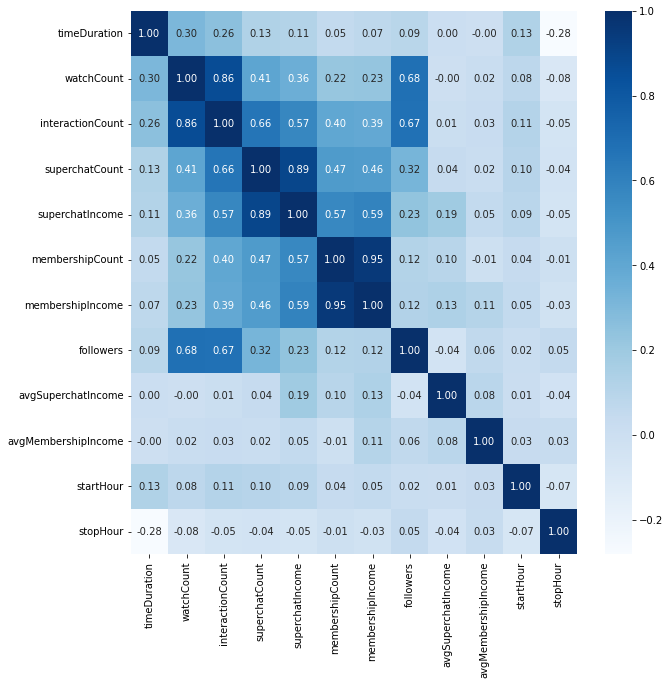

In [33]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

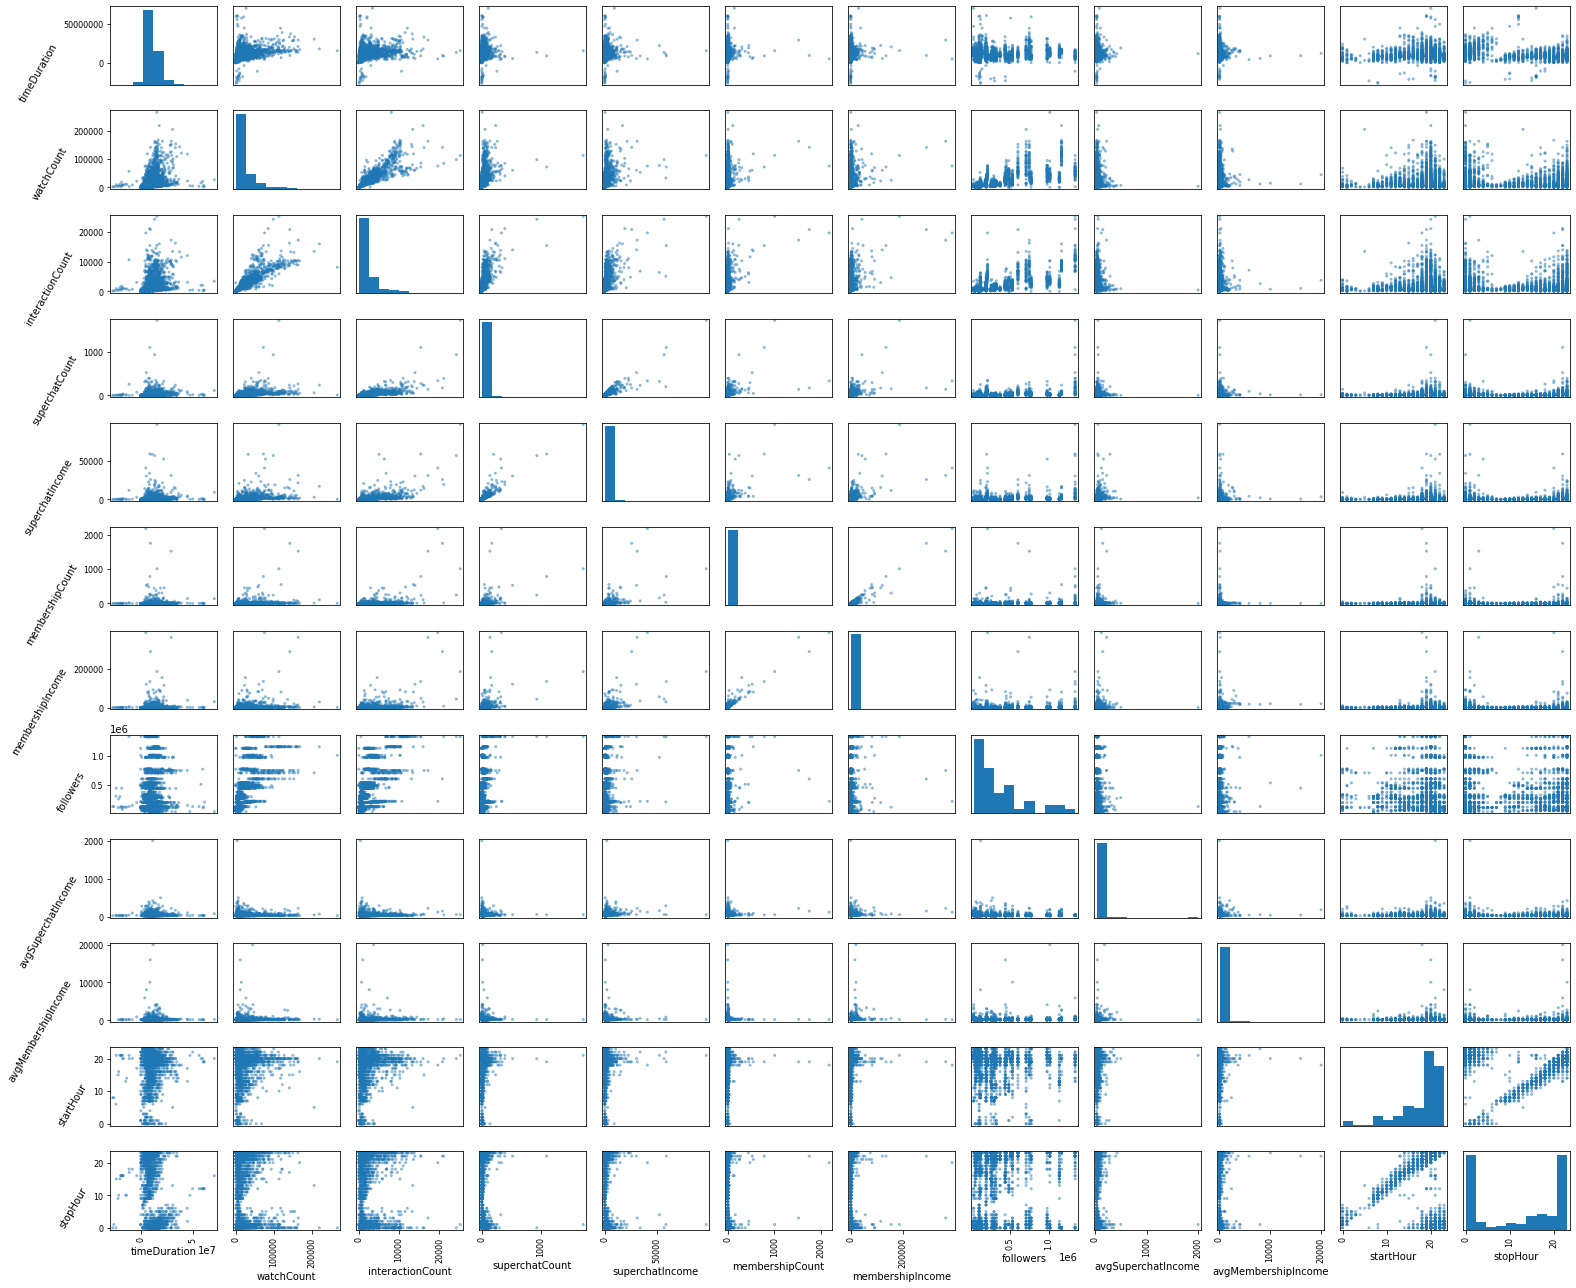

In [34]:
axes = scatter_matrix(df, figsize=(22, 18))
for ax in axes.flatten():
    ax.yaxis.label.set_rotation(60)
    ax.yaxis.label.set_ha('right')
plt.tight_layout()
plt.show()

好了，数据拿到了，可以开始吹了。我在这里放弃了总收入和弹幕数量的比较，因为它们显然可以通过 sc /舰长收入和互动人数来推演得到。首先比较惊讶的一点是，相关性矩阵的数值居然基本都是正数，这说明这组数据基本上都是正相关的，可能这就是所谓的赢者通吃罢。可以注意到的是直播时长和收入没啥关系，反而是和互动人数/观看人数/下播时间相关性更高。然后观看人数和互动人数/粉丝数量的相关性也很高，这也是符合常理的。

在 sc 数量/舰长数量和 sc 收入/舰长收入的比较中，我们可以看到 sc 数量/舰长数量和 sc 收入/舰长收入的相关性都很高，而舰长上的数据相关性更好，可能是由于 sc 的金额选择更加自由，而一般人只会上 138/198 元的舰长造成的。还有就是下播时间和其他数据基本都是负相关，这大概是由于我们采用了东八区修正导致而主播更加倾向于凌晨下播。

总而言之，在这一节我们得到了一些显而易见的结论，也没有提出什么新的设想，所以我们在之后会讨论一些别的方向。

### 时间和sc/舰长数量的关系

尽管在上面的章节中我们并没有发现开播和下播时间和 sc/舰长数量的关系，但是我仍然相信他们之间存在一定的联系。因为很显然，sc 和舰长的数量增长是会需要一个特定的时间段的，例如一场 2 小时的直播，其 sc 和舰长的数量不可能是平均增长的，所以我们需要一个更加细致的时间刻度来分析这些数据。

不过可惜的是，我们并没有收集每一个 sc 和舰长的单价，不过我也懒得再花一天时间去重爬这些数据了。总而言之，大部分的 sc 的价格为 30 元或者 50 元人民币，而舰长的价格为 138 元或者 198 元人民币。在极少情况下会出现大额的红色 sc 以及价值 1998 元的提督和价值 19998 元的总督。当然如果我们得到了有趣的结论，或许在未来会进一步分析价格和时间之间的关系。

由于在 bilibili 观看虚拟主播的观众大部分位于 UTC+8 的时区，其作息也和时区相符，所以我们在这里将 UTC 的时间戳转换为 UTC+8 的时间戳。

**注意**：下方图中的折线代表该时间段正在直播的主播数量，柱状图表示在这一个小时内 sc/舰长 的数量。

Text(0, 0.5, 'Number of superchats in hour')

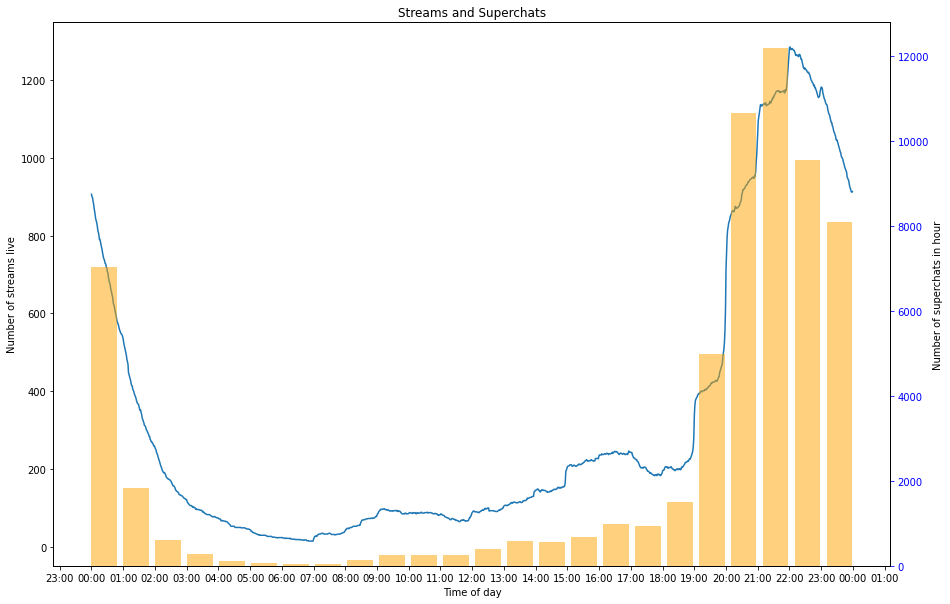

In [52]:
from datetime import time, date, timedelta, datetime

datetimes = {}
scs = {}
mbs = {}

for _, row in df.iterrows():
    ct = row['startDate']
    while ct <= row['stopDate']:
        t = datetime.combine(date(2000, 1, 1),
                             ct.replace(second=0, microsecond=0).time())
        t += timedelta(hours=8)
        t = t.replace(day=1)
        if t in datetimes:
            datetimes[t] += 1
        else:
            datetimes[t] = 1
        ct += timedelta(minutes=1)
    for i in row['superchatTimestamps']:
        t1 = (i.hour + 8) % 24
        if t1 in scs:
            scs[t1] += 1
        else:
            scs[t1] = 1
    for i in row['membershipTimestamps']:
        t2 = (i.hour + 8) % 24
        if t2 in mbs:
            mbs[t2] += 1
        else:
            mbs[t2] = 1

x, y = zip(*sorted(datetimes.items()))
x2, y2 = zip(*sorted(scs.items()))
x3, y3 = zip(*sorted(mbs.items()))
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x, y)

ax2 = ax.twiny().twinx()
ax2.set_xticks([])
ax2.tick_params('y', colors='b')
ax2.bar(x2, y2, color='orange', alpha=0.5)

xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.set_title('Streams and Superchats')
ax.set_xlabel('Time of day')
ax.set_ylabel('Number of streams live')
ax2.set_ylabel('Number of superchats in hour')

这图就很有意思了，咱们仔细看看。

首先我们单看折线图，可以看到在整点左右，有大量的主播开播。这很好理解，因为很多主播都会先预定一个开播时间（大概率是整点），然后提前几分钟开始。然后我们可以看到在每个小时的中间段，折线的增速放缓或者开始下降，这说明主播下播的时间相较于开播来说不是特别固定。然后我们可以看到有大量的主播会选择在晚上八点开始直播，这大概是吃完晚饭的时间，可以说是“黄金时间”。而主播数量十点钟达到顶峰，应该说是为了照顾 996 的打工人嘛（。在此之后主播的数量会几乎匀速下降，在凌晨 2 点左右达到谷底。还有一部分虚拟主播会选择在下午开播，这可能是双休日或者午休摸鱼的时间，随后数量会在下午五点左右的晚饭时间下降。

Superchat 数量变化趋势从大体上看和主播数量变化相同，我们来想说“但是也会有一些例外情况”，然而，并没有，这可能是因为观众更倾向于在主播刚开播的时候发送 sc 。

Text(0, 0.5, 'Number of Memberships in hour')

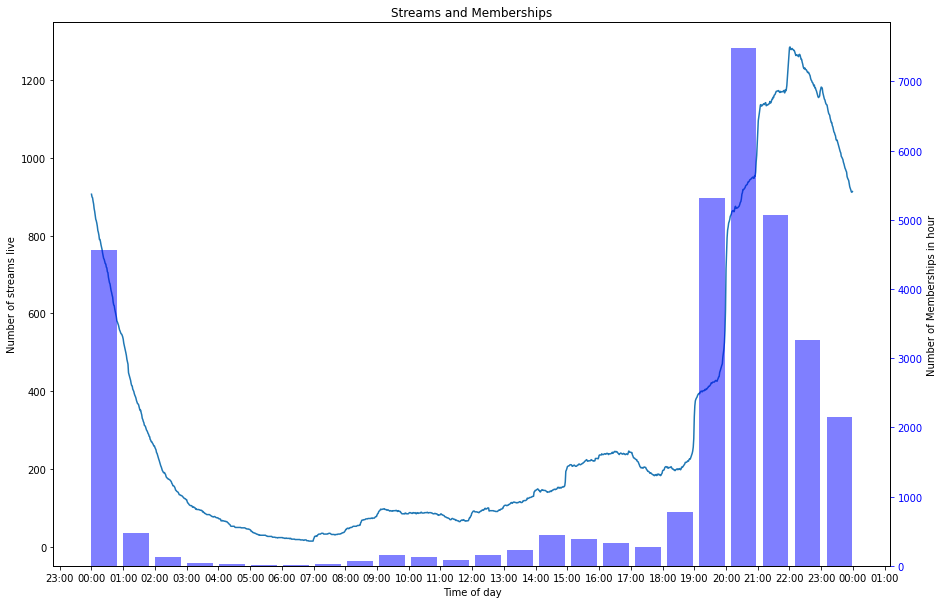

In [59]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x, y)

ax2 = ax.twiny().twinx()
ax2.set_xticks([])
ax2.tick_params('y', colors='b')
ax2.bar(x3, y3, color='blue', alpha=0.5)

xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.set_title('Streams and Memberships')
ax.set_xlabel('Time of day')
ax.set_ylabel('Number of streams live')
ax2.set_ylabel('Number of Memberships in hour')

大航海的情况和 sc 的情况类似，但是有趣的是它的顶峰和 sc 相比偏移了一个小时，在开播主播数量快速上升的 21 时，大航海的数量反而下降了。同时 19 时的舰长增幅远远超过了主播开播的数量，我认为可能舰长价格相对于 sc 而言更高，而只有更加忠实的观众才会选择购买舰长。因此舰长的数量变化取决于忠实观众观看直播的时间而不是主播开播的时间，观众往往也不会倾向于在主播刚开播的时候购买舰长。另一个有趣的点是 0 时的上舰数量可以和 21 时持平，应该是由于连续包月自动续费的原因。

#### 本章小结

尽管我们并没有进行定量分析也没有发现什么突破性的观点，但是我们确实也验证了一些普遍的认识。

- 主播往往倾向于在整点左右开播，因为这符合预定的开播时间。
- 晚饭后的时间是主播的 “黄金时间”。
- 工作时间会有更少的 sc 和舰长。
- 和 sc 不同，舰长数量和主播开播的时间不完全同步。

#### 未来工作

在这里我们定性地统计了每小时的 sc/舰长 数量，它和每分钟正在直播的主播数量相似。或许我们可以使用[柯尔莫哥洛夫 - 斯米尔诺夫检验](https://www.wikipedia.net/zh-hans/%E6%9F%AF%E5%B0%94%E8%8E%AB%E5%93%A5%E6%B4%9B%E5%A4%AB-%E6%96%AF%E7%B1%B3%E5%B0%94%E8%AF%BA%E5%A4%AB%E6%A3%80%E9%AA%8C)来检验两种分布之间是否相同。

### 观看/互动数量和 sc 收入的关系

这一部分开始，内容或许有一些数据挖掘的味道了。就我们的普遍认识而言，观众越多的主播能够赚到更多的钱，但是他们究竟遵从一个什么样的关系呢？是线性吗？还是指数？还是其他的什么？我们先画张图看看罢。

Text(0.5, 1.0, 'Interaction Count vs Superchat Earnings (linear scale)')

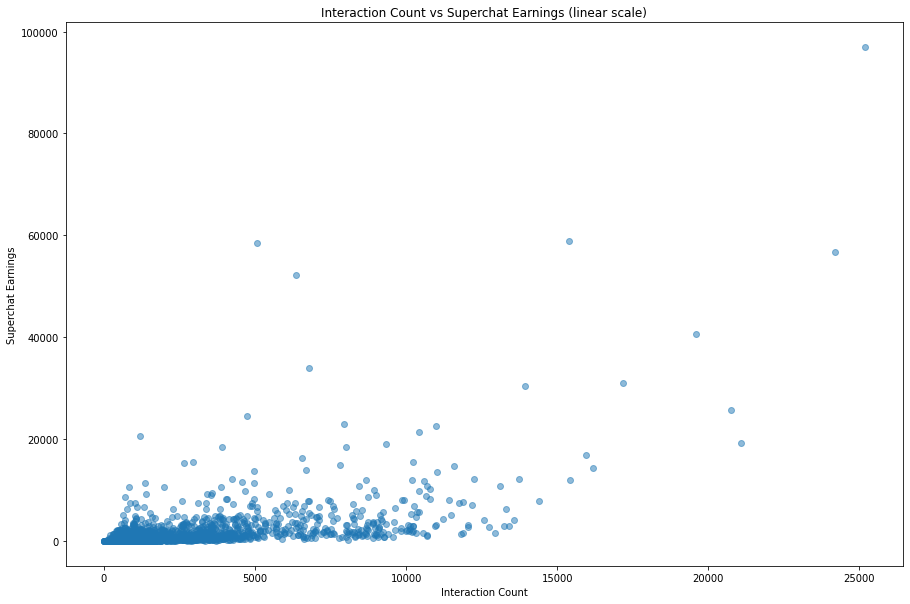

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df['interactionCount'] ,df['superchatIncome'], 'o', alpha = 0.5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (linear scale)")

emm...感觉很河里了，但是确实不能提供什么信息，因为低观众且低 sc 的数量太多了，而且我们也没有办法去除这些数据。我们可以使用[对数变换](https://www.wikipedia.net/zh-hans/%E5%AF%B9%E6%95%B0%E5%8F%98%E6%8D%A2)来解决这个问题。

Text(0.5, 1.0, 'Interaction Count vs Superchat Earnings (log-log scale)')

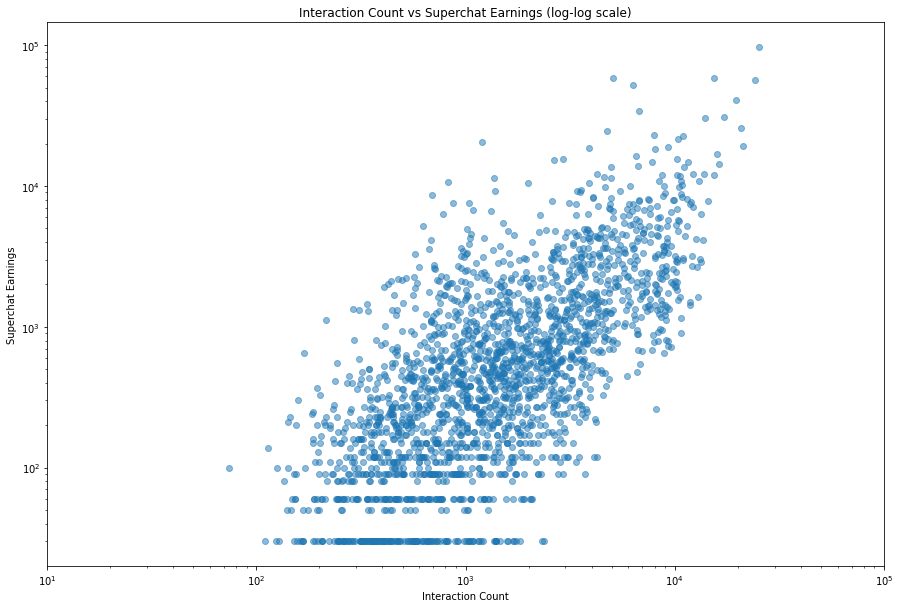

In [72]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df['interactionCount'] ,df['superchatIncome'], 'o', alpha = 0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(10, 1e5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (log-log scale)")

现在，我们可以得到更多的信息了。比如：

- 最下方有一条平行的线，它大概代表了 sc 的最低值（30元），然后另外也有几条平行线。它们代表了只有几个人发送小额 sc 的情况。
- 就趋势上看，我们可以看到一个上升的趋势。

然后，我们来尝试一下能不能拟合出这个趋势。

#### 注意，下面有一部分是反面教材

In [70]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['interactionCount'] ,df['superchatIncome'])
print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope, intercept))
print('p-value: %e'%(p_value))
print('r-value: %f'%(r_value))
print('standard error: %f'%(std_err))

Regression from scipy y=mx+b: 
y = 0.856222 x + -486.326623
p-value: 1.919459e-216
r-value: 0.573294
standard error: 0.024598


嘛， python 就是不错，几行代码就拟合出来了。这个 p 值看上去不错，但是这个 r 感觉就很一般，不过这都不是什么大问题。我们来看看这个拟合的直线。

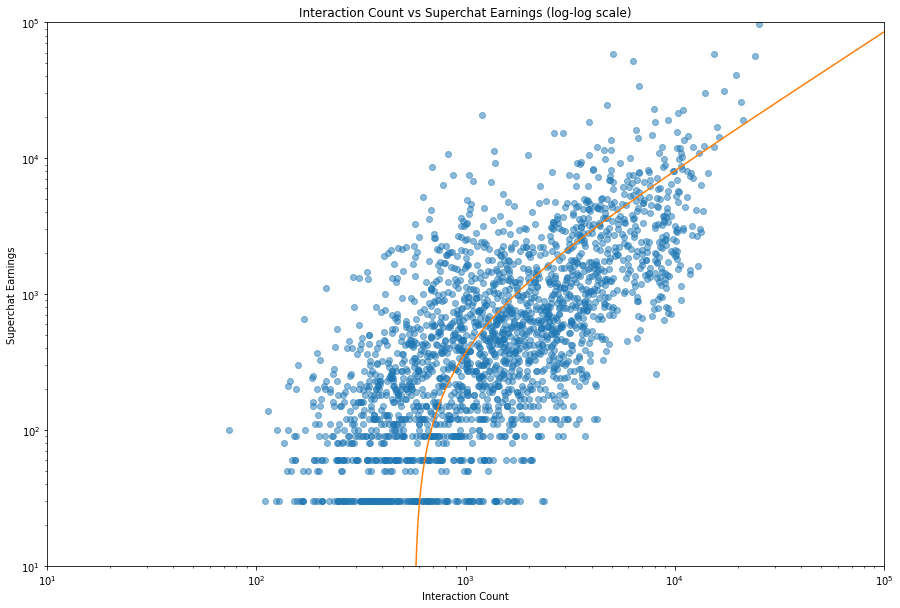

In [77]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df['interactionCount'] ,df['superchatIncome'], 'o', alpha = 0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(10, 1e5)
plt.ylim(10, 1e5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (log-log scale)")

x = np.array(range(10, 10**5, 5))
ax.plot(x, slope * x + intercept)
plt.show()

非常的神秘啊，这条线是一条曲线。雀氏，因为在 log-log 图里，想要得到一条直线需要一个类似于 $y=ax^k$ 的函数。尽管这条拟合的直线是*可以*的，但是我们还是希望能在 log-log 图里得到一条直线，这样才不会忽略数值过小的点。

为了得到一条指数拟合的曲线，我们有两种选择：

- 通过一些非常时尚的回归方法得到结果。
- 两边取对数，得到形如 $\log(y)=k\log(x)+\log(a)$ 的形式，然后进行线性拟合。

我们在这里会选择第二种方法，不过需要注意数据中有一些没有 sc 的数据，我们可以选择去掉它们或者令它的值为 0.01 元。这里我们选择去掉它们。

In [79]:
df_prime = df[['interactionCount', 'superchatIncome']]
df_prime = df_prime[df_prime['superchatIncome'] > 0]
df_prime['interactionCount'] = df_prime['interactionCount'].apply(math.log)
df_prime['superchatIncome'] = df_prime['superchatIncome'].apply(math.log)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_prime['interactionCount'], df_prime['superchatIncome'])
print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope, intercept))
print('p-value: %e'%(p_value))
print('r-value: %f'%(r_value))
print('r squared: %f'%(r_value**2))
print('standard error: %f'%(std_err))

Regression from scipy y=mx+b: 
y = 1.002485 x + -1.110788
p-value: 5.818056e-309
r-value: 0.689253
r squared: 0.475069
standard error: 0.022513


我们可以看到， r 值高了一些，感觉还行罢。我们来看看这条曲线。

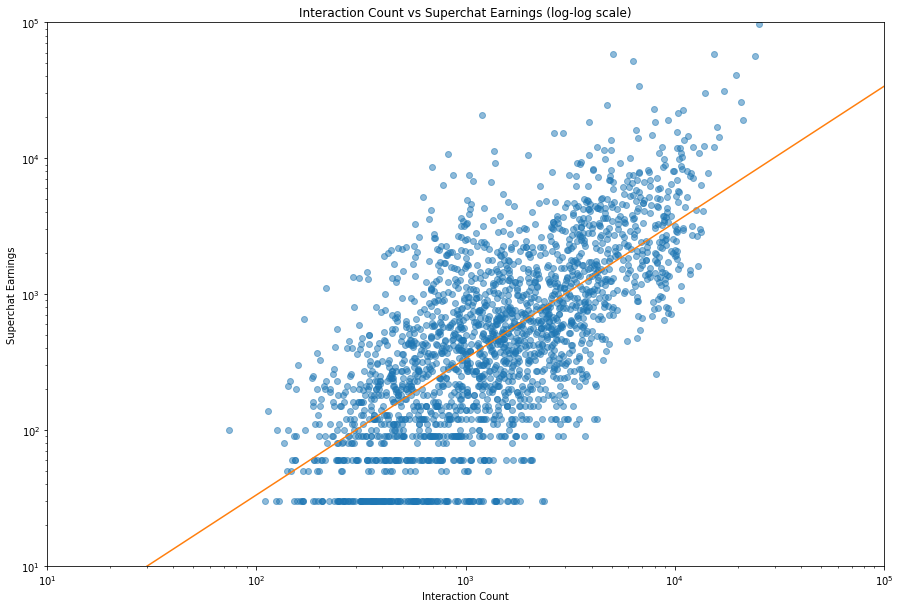

In [80]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df['interactionCount'], df['superchatIncome'], 'o', alpha = 0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(10, 1e5)
plt.ylim(10, 1e5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (log-log scale)")

x = np.array(range(10, 10**5, 5))
ax.plot(x, (math.e**intercept) * x**slope)
plt.show()

当然，我们可以给数据取对数而不是给坐标系取对数，这样其实对后面的处理更有好处。所幸，我们有了 `df_prime` ，所以只要把它拿来用就行了。

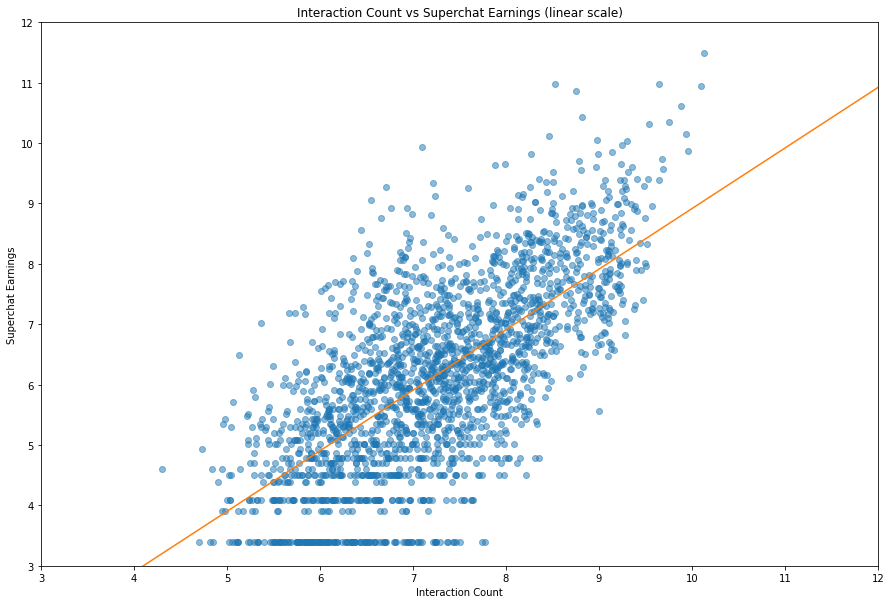

In [86]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_prime['interactionCount'], df_prime['superchatIncome'], 'o', alpha = 0.5)
plt.xlim(3, 12)
plt.ylim(3, 12)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (linear scale)")

x = np.array([i/10.0 for i in range(30,130)])
ax.plot(x, slope * x + intercept)
plt.show()

我们同样可以画出残差，来看看我们的回归效果咋样。

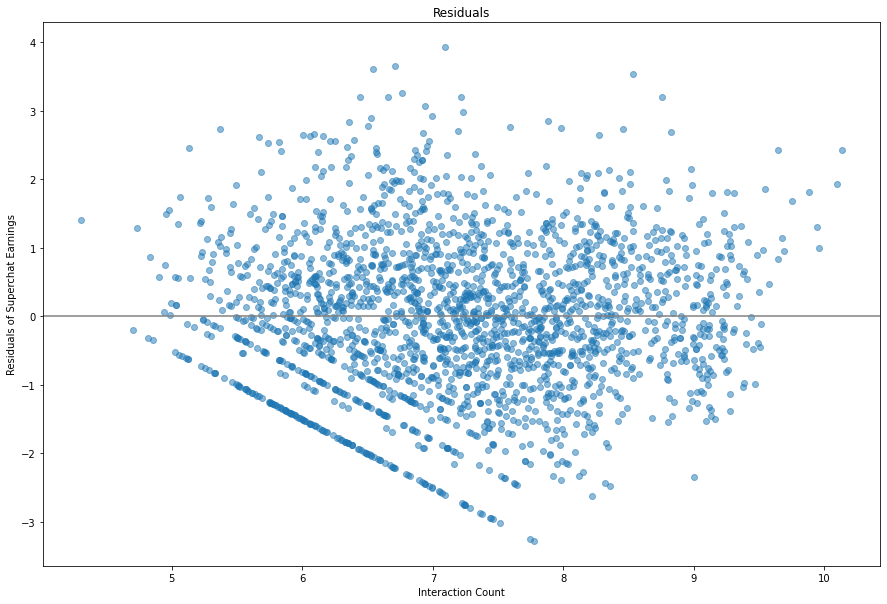

a =  0.3292993009957897
k =  1.0024851841520102


In [91]:
fig, ax = plt.subplots(figsize=(15, 10))

residuals = []
for _, row in df_prime.iterrows():
    residuals.append(row['superchatIncome'] - (slope * row['interactionCount'] + intercept))

ax.plot(df_prime['interactionCount'], residuals, 'o', alpha = 0.5)
ax.set_xlabel("Interaction Count")
ax.set_ylabel("Residuals of Superchat Earnings")
ax.set_title("Residuals")

ax.axhline(color='gray')
plt.show()

print("a = ", math.e**intercept)
print("k = ", slope)

看上去不错，我们可以将残差分成四个部分，然后看一看它的小提琴图。

<AxesSubplot:xlabel='interactionCount'>

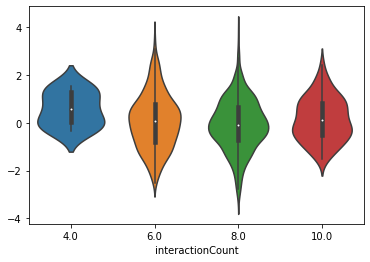

In [90]:
vc2 = df_prime['interactionCount'].apply(lambda x: round(x/2, 0) * 2)

sns.violinplot(x=vc2, y=residuals)

看上去分布很平均，除了数据值比较小的部分拟合地不是特别好，不过差异不算特别大。

最后我们可以说我们得到了这样的一个公式：

$$
y = 0.3292993009957897x^{1.0024851841520102}
$$

其中 $x$ 是互动人数， $y$ 是 sc 的收入。

#### 个人势 —— 好事还是坏事？

或许你已经注意到了，我选择了许多所属为 `independent` 的虚拟主播，他们代表的是不属于任何公司的个人势，那么他们的数据和平均相比有什么差异呢？

Regression from scipy y=mx+b: 
y = 1.161990 x + -2.306773
p-value: 6.064823e-114
r-value: 0.699629
r squared: 0.489481
standard error: 0.042877
a =  0.09958203755065093
k =  1.1619896703273997


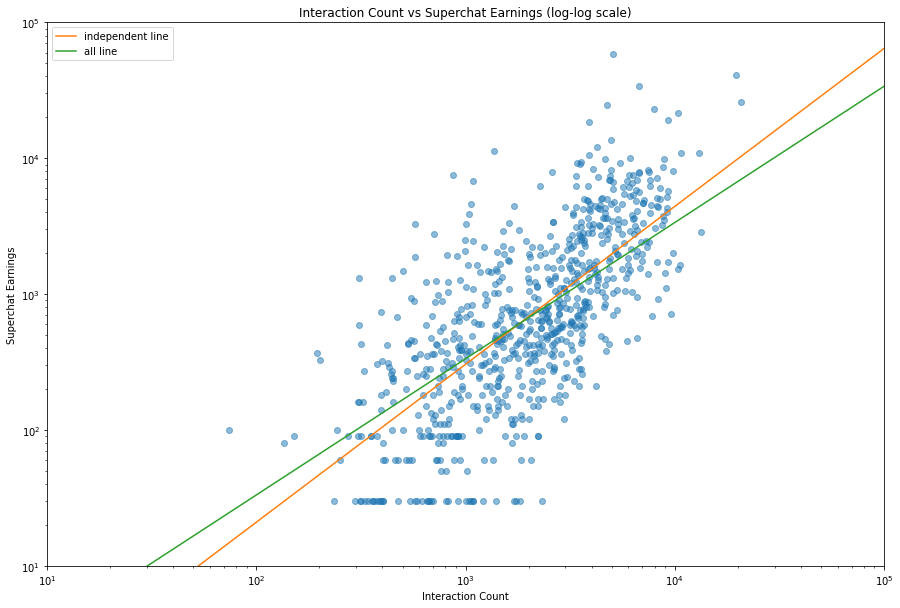

In [106]:
inde = c_names.loc[c_names['affiliation'] == 'independent']
inde = df.loc[df['liver'].isin(inde['name'])]

df_prime = inde[['interactionCount', 'superchatIncome']]
df_prime = df_prime[df_prime['superchatIncome'] > 0]
df_prime['interactionCount'] = df_prime['interactionCount'].apply(math.log)
df_prime['superchatIncome'] = df_prime['superchatIncome'].apply(math.log)

slope_prime, intercept_prime, r_value_prime, p_value_prime, std_err_prime = stats.linregress(df_prime['interactionCount'], df_prime['superchatIncome'])
print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope_prime, intercept_prime))
print('p-value: %e'%(p_value_prime))
print('r-value: %f'%(r_value_prime))
print('r squared: %f'%(r_value_prime**2))
print('standard error: %f'%(std_err_prime))
print('a = ', math.e**intercept_prime)
print('k = ', slope_prime)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(inde['interactionCount'], inde['superchatIncome'], 'o', alpha = 0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(10, 1e5)
plt.ylim(10, 1e5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (log-log scale)")

x = np.array(range(10, 10**5, 5))
ax.plot(x, (math.e**intercept_prime) * x**slope_prime, color='C1', label='independent line')
ax.plot(x, (math.e**intercept) * x**slope, color='C2', label='all line')
plt.legend(loc='upper left')
plt.show()

嗯，这组数据的 r 方更高，说明拟合地更好，但是只是好一点，不能好多了。橙色的线表示个人势主播的拟合数据，绿色的线表示总体的拟合数据。就两条曲线相交情况来看，个人势拥有更低的下限和更高的上限，很符合我的预期。而两条线的焦点差不多位于中央的位置，说明可以说中流的主播加入组织或者成为个人势确实差不多。不过考虑到工会会有所抽成之类的，所以只能说是头部主播个人势比较赚。

然后我们来看看不同的企业的数据，看看他们的拟合情况。由于数据量的关系，我们将他们分成三类 —— VirtualReal 、 PSP 和其他。

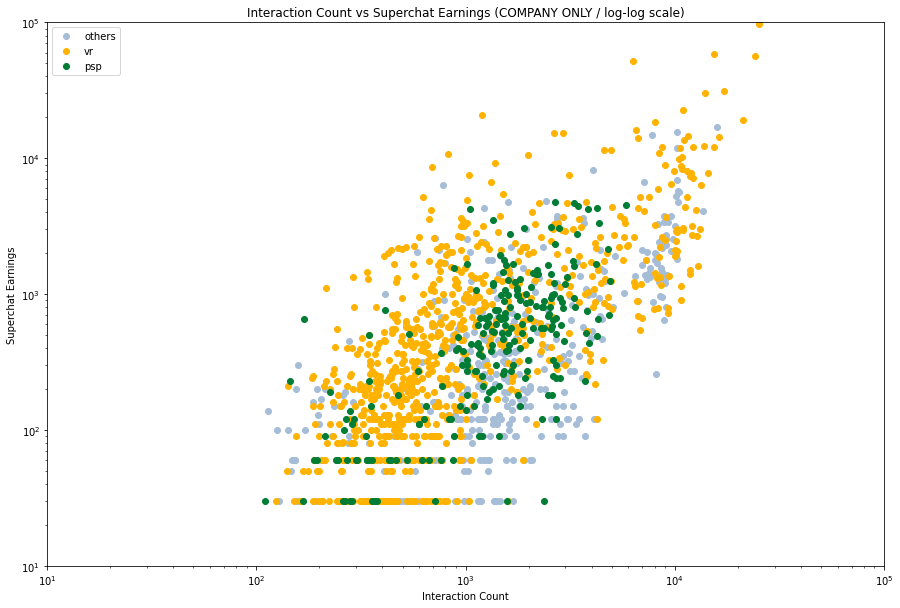

In [121]:
vr = c_names[c_names['affiliation'] == 'vr']
vr = df.loc[df['liver'].isin(vr['name'])]
psp = c_names[c_names['affiliation'] == 'psp']
psp = df.loc[df['liver'].isin(psp['name'])]
other = c_names.loc[~c_names['affiliation'].isin(['vr', 'psp', 'independent'])]
other = df.loc[df['liver'].isin(other['name'])]

COLORS = ['#A6BDD7', '#FFB300', '#007D34', '#F6768E']
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(other['interactionCount'], other['superchatIncome'], 'o', color=COLORS[0], label='others')
ax.plot(vr['interactionCount'], vr['superchatIncome'], 'o', color=COLORS[1], label='vr')
ax.plot(psp['interactionCount'], psp['superchatIncome'], 'o', color=COLORS[2], label='psp')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim(10, 1e5)
plt.ylim(10, 1e5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (COMPANY ONLY / log-log scale)")

plt.legend(loc='upper left')
plt.show()

然后我们仔细看看每个分类，然后分别加入拟合线。

Regression from scipy y=mx+b: 
y = 1.040950 x + -1.132949
p-value: 6.036379e-133
r-value: 0.726136
r squared: 0.527274
standard error: 0.034761


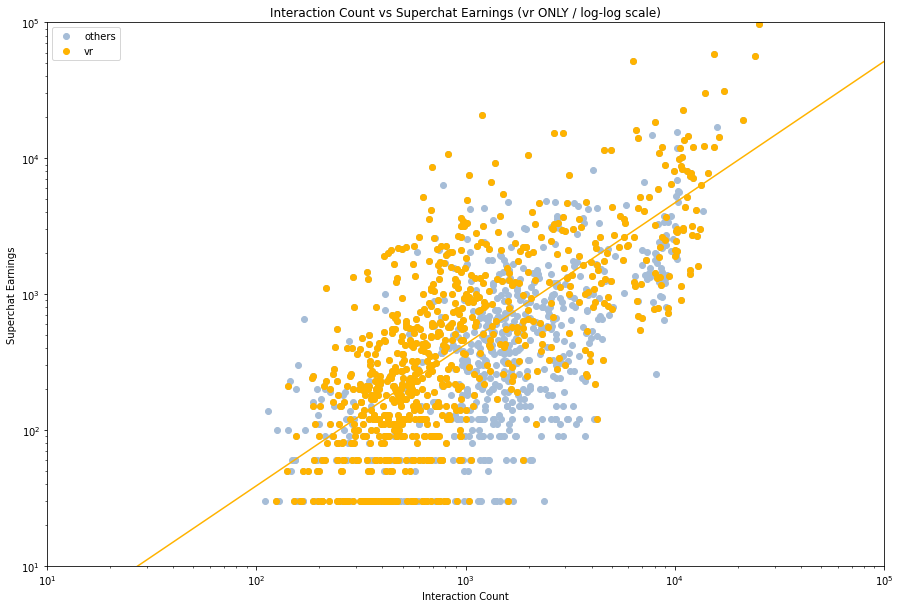

Regression from scipy y=mx+b: 
y = 1.046183 x + -1.505542
p-value: 3.293558e-34
r-value: 0.695976
r squared: 0.484382
standard error: 0.071959


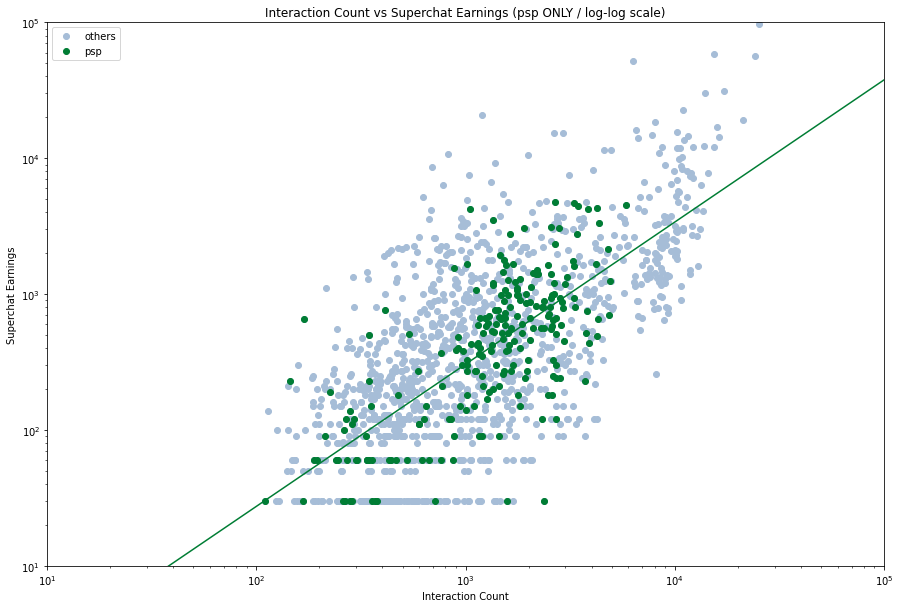

Regression from scipy y=mx+b: 
y = 0.874677 x + -0.643986
p-value: 1.790019e-44
r-value: 0.628465
r squared: 0.394969
standard error: 0.054818


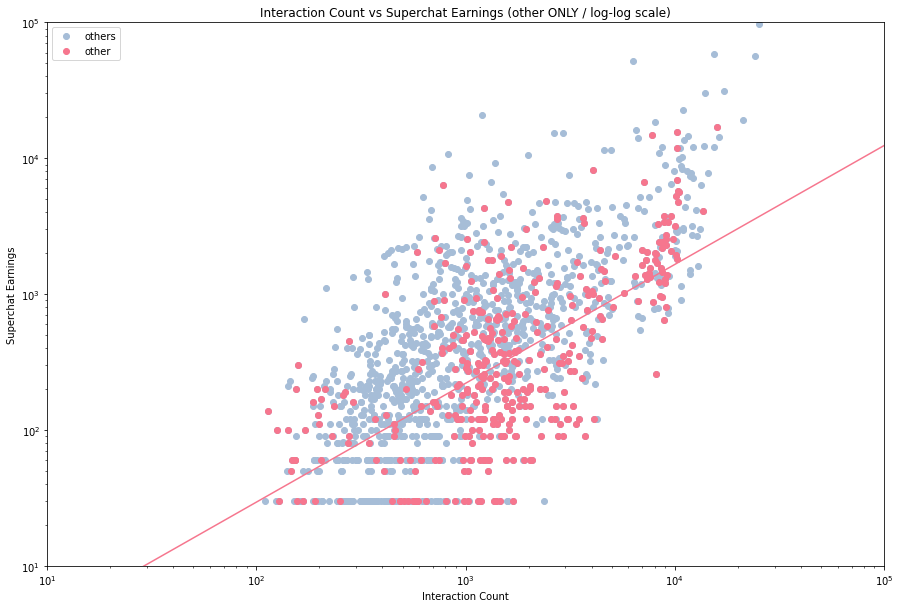

In [129]:
company = c_names[c_names['affiliation'] != 'independent']
company = df.loc[df['liver'].isin(company['name'])]

coms = [vr, psp, other]
labels = ['vr', 'psp', 'other']

x = np.array(range(10, 10**5, 5))
idx = 1

regs = []

for com in coms:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(company['interactionCount'], company['superchatIncome'], 'o', color=COLORS[0], label='others')
    ax.plot(com['interactionCount'], com['superchatIncome'], 'o', color=COLORS[idx], label=labels[idx-1])
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(10, 1e5)
    plt.ylim(10, 1e5)

    com_prime = com[['interactionCount', 'superchatIncome']]
    com_prime = com_prime[com_prime['superchatIncome'] > 0]
    com_prime['interactionCount'] = com_prime['interactionCount'].apply(math.log)
    com_prime['superchatIncome'] = com_prime['superchatIncome'].apply(math.log)
    slope_prime, intercept_prime, r_value_prime, p_value_prime, std_err_prime = stats.linregress(com_prime['interactionCount'], com_prime['superchatIncome'])
    print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope_prime, intercept_prime))
    print('p-value: %e'%(p_value_prime))
    print('r-value: %f'%(r_value_prime))
    print('r squared: %f'%(r_value_prime**2))
    print('standard error: %f'%(std_err_prime))

    ax.plot(x, (math.e**intercept_prime) * x**slope_prime, color=COLORS[idx])
    regs.append([slope_prime, intercept_prime])

    ax.set_xlabel("Interaction Count")
    ax.set_ylabel("Superchat Earnings")
    ax.set_title("Interaction Count vs Superchat Earnings ({0} ONLY / log-log scale)".format(labels[idx-1]))

    idx += 1
    plt.legend(loc='upper left')
    plt.show()

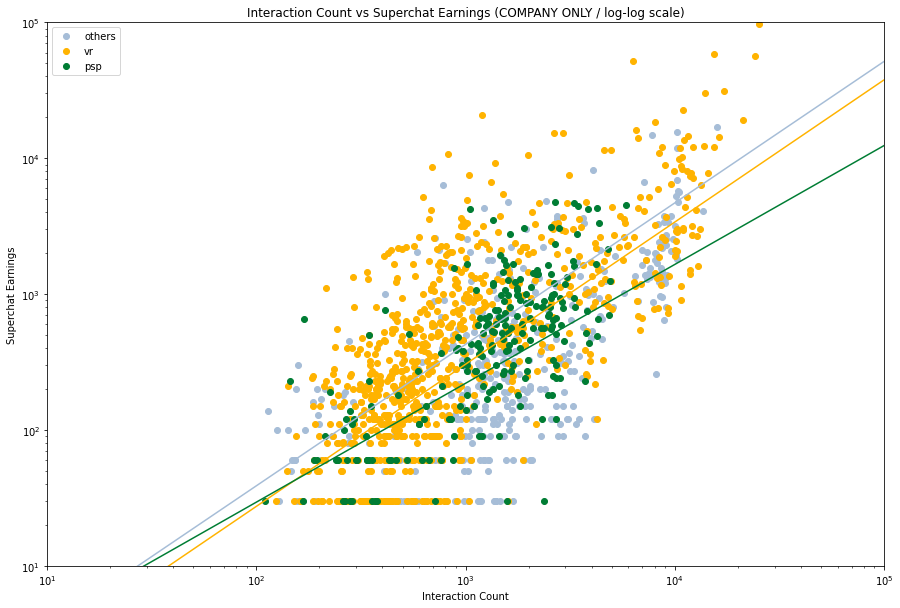

In [130]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(other['interactionCount'], other['superchatIncome'], 'o', color=COLORS[0], label='others')
ax.plot(vr['interactionCount'], vr['superchatIncome'], 'o', color=COLORS[1], label='vr')
ax.plot(psp['interactionCount'], psp['superchatIncome'], 'o', color=COLORS[2], label='psp')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim(10, 1e5)
plt.ylim(10, 1e5)

ax.set_xlabel("Interaction Count")
ax.set_ylabel("Superchat Earnings")
ax.set_title("Interaction Count vs Superchat Earnings (COMPANY ONLY / log-log scale)")

idx = 0

for reg in regs:
    ax.plot(x, (math.e**reg[1]) * x**reg[0], color=COLORS[idx])
    idx += 1

plt.legend(loc='upper left')
plt.show()

很明显，不同的企业会有不同的拟合曲线，甚至有一种 PSP 行将就木的感觉。就数据上看，其他类的主播表现最好，但是其实这也是我们数据选取的结果，体量相对小的企业容易捧出更加热门的主播，而像 VR 这样走量的企业就会有上下限差异比较大的情况。

#### 本章总结

- 我们定量分析了虚拟主播互动人数和 sc 收入之间的关系，得到了一个指数拟合的曲线。
- 就个人势来看，他们的收入水平处于一种下限更低但是上限更高的状态。
- 企业势中，选择一个冷门的企业或许是一个好的选择。

## 整点机器学习

机器学习，他来了。在这里我们想看一看多因素作用下的 sc/舰长 收入情况，以及不同的主播是否有直播标题的用语偏好。笼统的来说，前者属于回归问题，后者属于分类问题。

首先隆重介绍 scikit-learn algorithm cheat-sheet ，它可以帮助我们快速选择合适的算法。

![](ml_map.png)

### 回归

我们想用 `timeDuration` / `followers` / `watchCount` / `interactionCount` 来预测 `superchatIncome` 和 `membershipIncome` 。根据上面的图，我们可以选择 `Lasso` 或者 `ElasticNet` 。但是在实际操作过程中，我发现这俩都不如直接线性回归$^1$。

$^1$ 事实上，这两种方法均基于线性回归（使用最小平方作为 loss 函数），`Lasso` 使用 L1 正则化，`ElasticNet` 使用 L1 和 L2 混合正则化。

In [179]:
import sklearn.linear_model

ml = df[['timeDuration', 'followers', 'watchCount', 'interactionCount', 'superchatIncome', 'membershipIncome']]

ml = ml[ml['superchatIncome'] > 0]
ml = ml[ml['membershipIncome'] > 0]
ml = ml[ml['watchCount'] > 0]
ml['timeDuration'] /= 60000
ml['followers'] = ml['followers'].apply(math.log)
ml['watchCount'] = ml['watchCount'].apply(math.log)
ml['interactionCount'] = ml['interactionCount'].apply(math.log)
ml['superchatIncome'] = ml['superchatIncome'].apply(math.log)
ml['membershipIncome'] = ml['membershipIncome'].apply(math.log)

y = ml['superchatIncome']
y_prime = ml['membershipIncome']
X = ml[['timeDuration', 'followers', 'watchCount', 'interactionCount']]
X.head()

,timeDuration,followers,watchCount,interactionCount
1,197.414133,10.451118,8.502689,6.475433
2,141.032567,10.451118,8.126223,6.111467
3,248.708783,10.451118,8.401782,6.354370
4,781.364767,10.451118,8.603738,5.872118
5,125.739050,10.451118,7.900266,5.758902


In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['followers'], random_state = 2)

# linreg = sklearn.linear_model.Lasso(alpha=0.114514)
# linreg = sklearn.linear_model.ElasticNet(alpha=0.114514, l1_ratio=0.5)
linreg = sklearn.linear_model.LinearRegression()
linreg.fit(X_train, y_train)

print(linreg.coef_)
print(linreg.intercept_)

y_test_reg = linreg.predict(X_test)
y_train_reg = linreg.predict(X_train)

accuracy_train = linreg.score(X_train, y_train)
accuracy_test = linreg.score(X_test, y_test)


print("Regression r^2 on training data: %f"%accuracy_train)
print("Regression r^2 on test data: %f"%accuracy_test)

X_train, X_test, y_train, y_test = train_test_split(X, y_prime, stratify=X['followers'], random_state = 2)

# linreg = sklearn.linear_model.Lasso(alpha=0.114514)
# linreg = sklearn.linear_model.ElasticNet(alpha=0.114514, l1_ratio=0.5)
linreg_2 = sklearn.linear_model.LinearRegression()
linreg_2.fit(X_train, y_train)

print(linreg_2.coef_)
print(linreg_2.intercept_)

y_test_reg = linreg_2.predict(X_test)
y_train_reg = linreg_2.predict(X_train)

accuracy_train = linreg_2.score(X_train, y_train)
accuracy_test = linreg_2.score(X_test, y_test)


print("Regression r^2 on training data: %f"%accuracy_train)
print("Regression r^2 on test data: %f"%accuracy_test)

[-1.63048556e-04 -4.61383946e-01 -1.58369967e-01  1.42841418e+00]
3.1673691472447825
Regression r^2 on training data: 0.496148
Regression r^2 on test data: 0.583907
[ 2.62559317e-04 -3.05417414e-01 -8.41857302e-02  9.09382138e-01]
4.756933767749846
Regression r^2 on training data: 0.233466
Regression r^2 on test data: 0.277448


综上，模型告诉我们：

$$
\log(\text{superchatIncome}) = {-0.000163048556}\text{timeDuration} - {0.461383946}\log(\text{followers}) - {0.158369967}\log(\text{watchCount}) + {1.42841418}\log(\text{interactionCount}) + 3.1673691472447825 \\
\log(\text{membershipIncome}) = {0.000262559317}\text{timeDuration} - {0.305417414}\log(\text{followers}) - {0.0841857302}\log(\text{watchCount}) + {0.909382138}\log(\text{interactionCount}) + 4.756933767749846
$$

而前者的 r 方大约在 0.55 左右，这比之前我们的预测要高多了。当然我们也不期望能得到一个十分厉害的公式，比较人类的行为不可预测。最后我们来算一算残差。

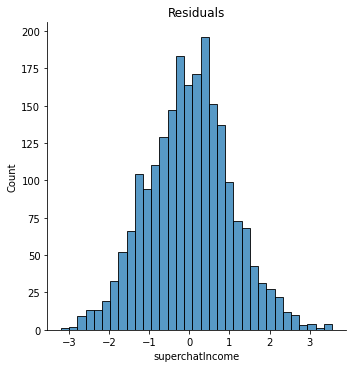

In [166]:
y_hat = linreg.predict(X)
sns.displot(y - y_hat)
plt.title("Residuals")

嗯，看上去非常的正态分布，而且大致上围绕 $0$ 对称，这是一个很好的结果。这个模型给了我们一个思路，也就是互动人数相对来说更加重要，而观众数量和粉丝数量在某种意义上来说可能会有副作用。当然，如果我们去掉 `interactionCount` 和 `watchCount` ，那么这个模型会更加有意义。

In [183]:
X_2 = X.drop('interactionCount', axis=1).drop('watchCount', axis=1)
X_2.head()

,timeDuration,followers
1,197.414133,10.451118
2,141.032567,10.451118
3,248.708783,10.451118
4,781.364767,10.451118
5,125.739050,10.451118


In [185]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, stratify=X['followers'], random_state = 2)

# linreg = sklearn.linear_model.Lasso(alpha=0.114514)
# linreg = sklearn.linear_model.ElasticNet(alpha=0.114514, l1_ratio=0.5)
linreg = sklearn.linear_model.LinearRegression()
linreg.fit(X_train_2, y_train_2)

print(linreg.coef_)
print(linreg.intercept_)

y_test_reg = linreg.predict(X_test_2)
y_train_reg = linreg.predict(X_train_2)

accuracy_train_2 = linreg.score(X_train_2, y_train_2)
accuracy_test_2 = linreg.score(X_test_2, y_test_2)


print("Regression r^2 on training data: %f"%accuracy_train_2)
print("Regression r^2 on test data: %f"%accuracy_test_2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_prime, stratify=X['followers'], random_state = 2)

# linreg = sklearn.linear_model.Lasso(alpha=0.114514)
# linreg = sklearn.linear_model.ElasticNet(alpha=0.114514, l1_ratio=0.5)
linreg_2 = sklearn.linear_model.LinearRegression()
linreg_2.fit(X_train_2, y_train_2)

print(linreg_2.coef_)
print(linreg_2.intercept_)

y_test_reg = linreg_2.predict(X_test_2)
y_train_reg = linreg_2.predict(X_train_2)

accuracy_train_2 = linreg_2.score(X_train_2, y_train_2)
accuracy_test_2 = linreg_2.score(X_test_2, y_test_2)


print("Regression r^2 on training data: %f"%accuracy_train_2)
print("Regression r^2 on test data: %f"%accuracy_test_2)

[0.00242135 0.45857431]
0.1472356138320805
Regression r^2 on training data: 0.122934
Regression r^2 on test data: 0.112910
[0.00194852 0.29509566]
2.8008611812800313
Regression r^2 on training data: 0.064087
Regression r^2 on test data: 0.052279


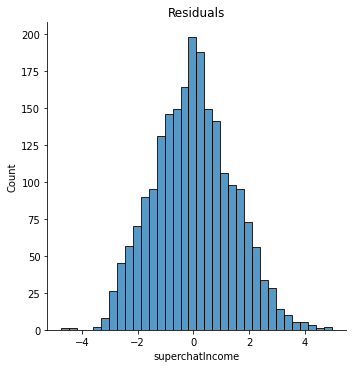

In [177]:
y_hat_2 = linreg.predict(X_2)
sns.displot(y - y_hat_2)
plt.title("Residuals");

所以，模型说：

$$
\log(\text{superchatIncome}) = {0.00242135}\text{timeDuration} + {0.45857431}\log(\text{followers}) + 0.1472356138320805 \\
\log(\text{membershipIncome}) = {0.00194852}\text{timeDuration} + {0.29509566}\log(\text{followers}) + 2.8008611812800313
$$

这就可以让主播根据自己的粉丝数量和想要直播的长度来估算自己的收入水平。

### 分类

我们的目标是给出一段字符来判断这是属于哪个主播的直播间标题。根据上面的 cheatsheet ，我们可以使用 `naiveBayes` 方法。

首先我们进行一个数据预处理，把所有的主播名称转换为 id ，这样方便模型训练。

In [192]:
ml_nb = df[['liver', 'title']]
ml_nb['liver_id'] = ml_nb['liver'].factorize()[0]
liver_id_df = ml_nb[['liver', 'liver_id']].drop_duplicates().sort_values('liver_id')
liver_to_id = dict(liver_id_df.values)
id_to_liver = dict(liver_id_df[['liver_id', 'liver']].values)

ml_nb.sample(10)

C:\Users\25688\AppData\Local\Temp\ipykernel_7108\1680955671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_nb['liver_id'] = ml_nb['liver'].factorize()[0]


,liver,title,liver_id
299,九十九_Tsukumo,《好九不见》,5
1386,步玎Pudding,最期待的原神3.2主线,27
58,りんうらん霖雨蘭,【B限】英雄联盟手游K/DA！可爱qq！,1
1534,瑞娅_Rhea,稍微说一会就去睡觉,30
2036,茶冷_Channel,茶冷复播，答记者问,41
2132,路希维德Wiede,元宵快乐,43
169,东爱璃Lovely,出道1000天啦！,3
1746,红晓音Akane,【环】突击初代艾尔登之王！,35
2065,茶冷_Channel,3D化后日谈+沉浸式低音谢礼物,41
566,可妮Koni_Official,睡眠导入原神~,11


然后我们就需要对中文进行一些预处理工作，删掉文本中的标点符号和特殊符号，由于这里只是标题，所以我们觉得不需要去除停用词。最后我们使用 `jieba` 库进行分词。

In [196]:
import re
import jieba as jb

def remove_punctuations(text):
    line = str(text)
    if line.strip() == '':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

ml_nb['clean_title'] = ml_nb['title'].apply(remove_punctuations)
ml_nb['cut_title'] = ml_nb['clean_title'].apply(lambda x: ' '.join(jb.cut(x)))
ml_nb.sample(10)

C:\Users\25688\AppData\Local\Temp\ipykernel_7108\2254722205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_nb['clean_title'] = ml_nb['title'].apply(remove_punctuations)
Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\25688\AppData\Local\Temp\jieba.cache
Loading model cost 2.479 seconds.
Prefix dict has been built successfully.
C:\Users\25688\AppData\Local\Temp\ipykernel_7108\2254722205.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_nb['cut_title'] 

,liver,title,liver_id,clean_title,cut_title
2331,雪绘Yukie,一起来看游戏王GX！！,47,一起来看游戏王GX,一起 来看 游戏王 GX
2136,路希维德Wiede,密码？那是什么？？,43,密码那是什么,密码 那 是 什么
730,奈姬Niki,来一把,14,来一把,来 一把
1588,病院坂Rei,【歌杂】小幽灵唱歌喽！,31,歌杂小幽灵唱歌喽,歌杂 小 幽灵 唱歌 喽
1681,眞白花音_Official,【B限】圣诞节做料理直播,33,B限圣诞节做料理直播,B 限 圣诞节 做 料理 直播
289,九十九_Tsukumo,《整理房间unpacking》,5,整理房间unpacking,整理 房间 unpacking
1271,李豆沙_Channel,歌杂并水友连麦,25,歌杂并水友连麦,歌杂 并 水友 连麦
2052,茶冷_Channel,【工作音杂谈】安定的周日夜晚,41,工作音杂谈安定的周日夜晚,工作 音 杂谈 安定 的 周日 夜晚
1049,折原露露,我到家啦！！冲一下五十万关注！,21,我到家啦冲一下五十万关注,我 到 家 啦 冲 一下 五十万 关注
116,七海Nana7mi,玩空之要塞：启航！,2,玩空之要塞启航,玩空 之 要塞 启航


emmm...虽然看上去效果一般般，有一些连在一起的词语也被切开了，不过要啥自行车。接下来我们需要计算一下 TF-IDF 矩阵，然后就可以训练模型了。

In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(norm='l2', encoding='utf-8', ngram_range=(1, 2))
features = tfidf.fit_transform(ml_nb.cut_title)
labels = ml_nb.liver_id

print(features.shape)
print(features)

(2477, 5043)
  (0, 4078)	0.3867751769048678
  (0, 2723)	0.3867751769048678
  (0, 698)	0.4070981099498189
  (0, 770)	0.3867751769048678
  (0, 4076)	0.3520328933911443
  (0, 2721)	0.3095641893240464
  (0, 697)	0.4070981099498189
  (1, 4554)	0.407098109949819
  (1, 4553)	0.407098109949819
  (1, 4078)	0.38677517690486785
  (1, 2723)	0.38677517690486785
  (1, 770)	0.38677517690486785
  (1, 4076)	0.35203289339114435
  (1, 2721)	0.30956418932404645
  (2, 3042)	0.6414193873794413
  (2, 497)	0.5424855617865706
  (2, 3041)	0.5424855617865706
  (3, 3383)	1.0
  (4, 1218)	0.48709901556647317
  (4, 297)	0.48709901556647317
  (4, 533)	0.40395968534382953
  (4, 1217)	0.4627823203088134
  (4, 296)	0.3848612668155245
  (5, 3650)	0.6518999645492638
  (5, 1726)	0.3873665866351113
  :	:
  (2468, 3669)	0.3454638440279449
  (2468, 3667)	0.6909276880558898
  (2468, 201)	0.31598150913221407
  (2468, 2204)	0.2544382305640776
  (2469, 3645)	0.44721359549995787
  (2469, 4159)	0.44721359549995787
  (2469, 274)	0.4

这里 `feature` 的形状是 `(2477, 5043)` ，前者表示标题数量，后者表示所有词语数 + 词语对的数量。然后我们就可以用朴素贝叶斯分类来计算啦。

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(ml_nb['cut_title'], ml_nb['liver_id'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

训练完成后，我们就可以让它来预测一下了。我们编写一个预测函数。

In [226]:
def predict_liver(text):
    text = remove_punctuations(text)
    text = ' '.join(jb.cut(text))
    return id_to_liver[clf.predict(count_vect.transform([text]))[0]]

我们以现在正在直播的主播来测试一下。

![](%E5%8B%BA.png)

In [227]:
predict_liver('收留失眠小狗 U・ェ・U')

'勺Shaun'

## 未来展望

其实我们还可以继续做一些工作，比如说：

- 在一周中不同的日子，直播的时长和收入会有什么变化？这和我们已经完成的分析有一定的关系，但是需要收集不同的数据。
- 关于一个 sc 的价格和大航海的类型与其他因素的关系，比如说直播时长，观众数量，粉丝数量等等。
- 特殊的直播（例如生日会/周年直播/耐久直播）和普通直播的收入差异。当然这就需要对数据手动进行分类了。

## 附录：数据集中包含的虚拟主播名单

点击用户 id 即可跳转到其 bilibili 空间。直播数据截至 2023 年 2 月 9 日。

|名称|所属|用户id|
|-|-|-|
|七海Nana7mi|vr|[434334701](https://space.bilibili.com/434334701)|
|中单光一|vr|[434401868](https://space.bilibili.com/434401868)|
|内德维德|independent|[90873](https://space.bilibili.com/90873)|
|弥希Miki|vr|[477317922](https://space.bilibili.com/477317922)|
|星弥Hoshimi|vr|[477342747](https://space.bilibili.com/477342747)|
|真绯瑠mahiru|vr|[477306079](https://space.bilibili.com/477306079)|
|阿萨Aza|vr|[480680646](https://space.bilibili.com/480680646)|
|雪绘Yukie|vr|[56748733](https://space.bilibili.com/56748733)|
|千春_Chiharu|vr|[558070433](https://space.bilibili.com/558070433)|
|悠亚Yua|vr|[666726799](https://space.bilibili.com/666726799)|
|勺Shaun|vr|[666726801](https://space.bilibili.com/666726801)|
|勾檀Mayumi|vr|[690608693](https://space.bilibili.com/690608693)|
|九十九_Tsukumo|vr|[690608702](https://space.bilibili.com/690608702)|
|瑞娅_Rhea|vr|[690608698](https://space.bilibili.com/690608698)|
|恋诗夜Koxia|vr|[690608690](https://space.bilibili.com/690608690)|
|雾深Girimi|vr|[1484169431](https://space.bilibili.com/1484169431)|
|茶冷_Channel|vr|[741520](https://space.bilibili.com/741520)|
|阿梓从小就很可爱|vr|[7706705](https://space.bilibili.com/7706705)|
|小可学妹|vr|[14387072](https://space.bilibili.com/14387072)|
|诺莺Nox|vr|[529249](https://space.bilibili.com/529249)|
|红晓音Akane|psp|[899804](https://space.bilibili.com/899804)|
|东爱璃Lovely|psp|[3821157](https://space.bilibili.com/3821157)|
|李豆沙_Channel|psp|[1703797642](https://space.bilibili.com/1703797642)|
|白神遥Haruka|psp|[477332594](https://space.bilibili.com/477332594)|
|病院坂Rei|psp|[1041474702](https://space.bilibili.com/1041474702)|
|夏诺雅_shanoa|independent|[1612112](https://space.bilibili.com/1612112)|
|雫るる_Official|independent|[387636363](https://space.bilibili.com/387636363)|
|明前奶绿|independent|[2132180406](https://space.bilibili.com/2132180406)|
|九重紫Official|independent|[225347042](https://space.bilibili.com/225347042)|
|-阿蕊娅Aria-|independent|[10850238](https://space.bilibili.com/10850238)|
|步玎Pudding|independent|[416622817](https://space.bilibili.com/416622817)|
|烛灵儿Hikari|independent|[399815233](https://space.bilibili.com/399815233)|
|胡桃Usa|providence|[12497617](https://space.bilibili.com/12497617)|
|花花Haya|providence|[269415357](https://space.bilibili.com/269415357)|
|路希维德Wiede|meta-mythos|[2006452883](https://space.bilibili.com/2006452883)|
|美月もも|independent|[2073012767](https://space.bilibili.com/2073012767)|
|早稻叽|chaoslive|[1950658](https://space.bilibili.com/1950658)|
|尼奈nine_Official|independent|[163653](https://space.bilibili.com/163653)|
|陆鳐LuLu|independent|[1856528671](https://space.bilibili.com/1856528671)|
|罗菈Rola|another-project|[2052064438](https://space.bilibili.com/2052064438)|
|奈姬Niki|another-project|[3035105](https://space.bilibili.com/3035105)|
|折原露露|independent|[631070414](https://space.bilibili.com/631070414)|
|可妮Koni_Official|independent|[1372936974](https://space.bilibili.com/1372936974)|
|眞白花音_Official|chucolala|[401480763](https://space.bilibili.com/401480763)|
|奈奈莉娅Channel|independent|[489146840](https://space.bilibili.com/489146840)|
|小柔Channel|虚研社|[1734978373](https://space.bilibili.com/1734978373)|
|艾露露Ailurus|虚研社|[1501380958](https://space.bilibili.com/1501380958)|
|りんうらん霖雨蘭|independent|[34815578](https://space.bilibili.com/34815578)|
|永雏塔菲|independent|[1265680561](https://space.bilibili.com/1265680561)|
|東雪蓮Official|independent|[1437582453](https://space.bilibili.com/1437582453)|

别问为什么内德维德会夹在一群 vr 主播中，问就是某个龙神的数据不知为何无法抓取临时换的。